In [737]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import shape, LineString
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import Pycluster as pc
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

% matplotlib inline

In [37]:
# Load the data matrices (NB 2 parts due to restrictions on download size from nomis)
# Columns are Waltham Forest 2011 LSOAs - home locations
# Rows are Workplace zones for all of London, and proximal East and South East region.

# Part 1
part1 = pd.read_csv('../Data/274122159.csv',header=7,skip_blank_lines=True)
part1.drop(' ',axis=1, inplace=True)
part1.rename(columns= {' .1':'wz2011'},inplace = True)

#Part 2
part2 = pd.read_csv('../Data/2353810085.csv',header=7,skip_blank_lines=True)
part2.drop(' ',axis=1, inplace=True)
part2.rename(columns= {' .1':'wz2011'},inplace = True)

# Merge the datasets by wz2011
flows = part1.merge(part2, on= 'wz2011')
# Remove disclosure control warning from end of dataset
flows = flows[:-4]
flows.head()

,wz2011,E01004412,E01004465,E01004466,E01004467,E01004468,E01004406,E01004408,E01004409,E01004411,...,E01004410,E01004464,E01004469,E01004470,E01004471,E01004391,E01004393,E01004401,E01004404,E01004461
0,E33032182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E33032183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E33032184,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E33029031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,E33032185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Now I'll just subset out the LSOAs that belong to Waltham Forest.
WFlsoas = flows.columns[1:]

# And the workplace zones that we're considering.
WFwzs = flows['wz2011'].values

# Now let's convert the flow matrix to a pairwise structure.
# First melt the dataframe
flows_melt = pd.melt(flows,id_vars=['wz2011'],value_vars=WFlsoas,var_name='lsoa11cd',value_name='flows')
# Remove the zero flows
flows_melt = flows_melt[flows_melt['flows'] > 0]
flows_melt.reset_index(drop=True,inplace=True)
# unbundle the multiple flows
flows_melt = pd.DataFrame([flows_melt.iloc[idx] 
                           for idx in flows_melt.index 
                           for _ in range(int(flows_melt.iloc[idx]['flows']))]).reset_index(drop=True)
# Finally, drop the now irrelevant flow count field
flows_melt.drop('flows',axis=1,inplace=True)
flows_melt.head()

,wz2011,lsoa11cd
0,E33032195,E01004412
1,E33032196,E01004412
2,E33032200,E01004412
3,E33032201,E01004412
4,E33032209,E01004412


In [23]:
# Get the LSOA to Ward lookup
lookup_url = 'https://opendata.arcgis.com/datasets/500d4283cbe54e3fa7f358399ba3783e_0.geojson'
    
# Access data with requests, take features info direct from the json
lookup_json = requests.get(lookup_url).json()['features']
# NB there is no geometry in this particular GeoJSON
attr = [d['properties'] for d in lookup_json]

# Now put data into pandas dataframe
lookup = pd.DataFrame(attr)
lookup.head()

,FID,LAD17CD,LAD17NM,LSOA11CD,LSOA11NM,WD17CD,WD17NM,WD17NMW
0,1,E09000001,City of London,E01000001,City of London 001A,E05009288,Aldersgate,None
1,2,E09000003,Barnet,E01000205,Barnet 035A,E05000052,Garden Suburb,None
2,3,E09000001,City of London,E01000002,City of London 001B,E05009302,Cripplegate,None
3,4,E09000001,City of London,E01000003,City of London 001C,E05009302,Cripplegate,None
4,5,E09000003,Barnet,E01000206,Barnet 033B,E05000052,Garden Suburb,None


In [39]:
# Add ward codes to the flows_melt table.
flows_melt = flows_melt.merge(lookup[['LSOA11CD','WD17CD','WD17NM']],left_on='lsoa11cd',right_on='LSOA11CD')
# Drop unneeded LSOA11CD field
flows_melt.drop('LSOA11CD',axis=1,inplace=True)
flows_melt.head()

,wz2011,lsoa11cd,WD17CD,WD17NM
0,E33032195,E01004412,E05000601,Hoe Street
1,E33032196,E01004412,E05000601,Hoe Street
2,E33032200,E01004412,E05000601,Hoe Street
3,E33032201,E01004412,E05000601,Hoe Street
4,E33032209,E01004412,E05000601,Hoe Street


In [25]:
# Now let's get the geospatial data
# lsoas
lsoa_url  = "https://opendata.arcgis.com/datasets/da831f80764346889837c72508f046fa_0.geojson"
lsoa_json = requests.get(lsoa_url).json()['features']
geom = [shape(d['geometry']) for d in lsoa_json]
attr = [d['properties'] for d in lsoa_json]
lsoas = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})
lsoas = lsoas.to_crs({'init':'epsg:27700'})

# WZ
wz_url = "https://opendata.arcgis.com/datasets/a399c2a5922a4beaa080de63c0a218a3_0.geojson"
wz_json = requests.get(wz_url).json()['features']
geom = [shape(d['geometry']) for d in wz_json]
attr = [d['properties'] for d in wz_json]
wz = gpd.GeoDataFrame(attr, geometry = geom, crs = {'init':'epsg:4326'})
wz = wz.to_crs({'init':'epsg:27700'})

# Now I'll just subset out the LSOAs that belong to Waltham Forest.
wf_lsoas = lsoas[lsoas['lsoa11cd'].isin(WFlsoas)]

# And the workplace zones that we're considering.
wf_wzs = wz[wz['wz11cd'].isin(WFwzs)]

In [26]:
# Make centroid representations of the geospatial data
p_wzs = gpd.GeoDataFrame(wf_wzs[wf_wzs.columns[:-1]],geometry=wf_wzs.centroid)
p_lsoas = gpd.GeoDataFrame(wf_lsoas[wf_lsoas.columns[:-1]],geometry=wf_lsoas.centroid)

# Now add the eastings and northings to the centroid geodataframes
p_lsoas['lsoa_x'] = p_lsoas['geometry'].centroid.x
p_lsoas['lsoa_y'] = p_lsoas['geometry'].centroid.y

p_wzs['wz_x'] = p_wzs['geometry'].centroid.x
p_wzs['wz_y'] = p_wzs['geometry'].centroid.y

In [40]:
# merge the eastings and northings with the flows data
#lsoas
flows_melt = flows_melt.merge(p_lsoas[['lsoa11cd','lsoa_x','lsoa_y']],on='lsoa11cd')
flows_melt = flows_melt.merge(p_wzs[['wz11cd','wz_x','wz_y']],left_on='wz2011',right_on='wz11cd')
flows_melt.head()

,wz2011,lsoa11cd,WD17CD,WD17NM,lsoa_x,lsoa_y,wz11cd,wz_x,wz_y
0,E33032195,E01004412,E05000601,Hoe Street,537775.269259,188781.062292,E33032195,548678.356322,187254.116956
1,E33032195,E01004406,E05000601,Hoe Street,537530.740735,188489.669872,E33032195,548678.356322,187254.116956
2,E33032195,E01004363,E05000595,Forest,538708.165950,188534.952282,E33032195,548678.356322,187254.116956
3,E33032195,E01004419,E05000602,Larkswood,537698.934179,191522.666325,E33032195,548678.356322,187254.116956
4,E33032195,E01004464,E05000609,Wood Street,538274.415134,189379.939640,E33032195,548678.356322,187254.116956


In [44]:
# Now we'll work out the distances
flows_melt['distance'] = flows_melt.apply(lambda x: np.sqrt(np.power(x['lsoa_x']-x['wz_x'],2) + np.power(x['lsoa_y']-x['wz_y'],2)),axis=1)
flows_melt.head()

,wz2011,lsoa11cd,WD17CD,WD17NM,lsoa_x,lsoa_y,wz11cd,wz_x,wz_y,distance
0,E33032195,E01004412,E05000601,Hoe Street,537775.269259,188781.062292,E33032195,548678.356322,187254.116956,11009.489977
1,E33032195,E01004406,E05000601,Hoe Street,537530.740735,188489.669872,E33032195,548678.356322,187254.116956,11215.878222
2,E33032195,E01004363,E05000595,Forest,538708.165950,188534.952282,E33032195,548678.356322,187254.116956,10052.125903
3,E33032195,E01004419,E05000602,Larkswood,537698.934179,191522.666325,E33032195,548678.356322,187254.116956,11779.992542
4,E33032195,E01004464,E05000609,Wood Street,538274.415134,189379.939640,E33032195,548678.356322,187254.116956,10618.903631


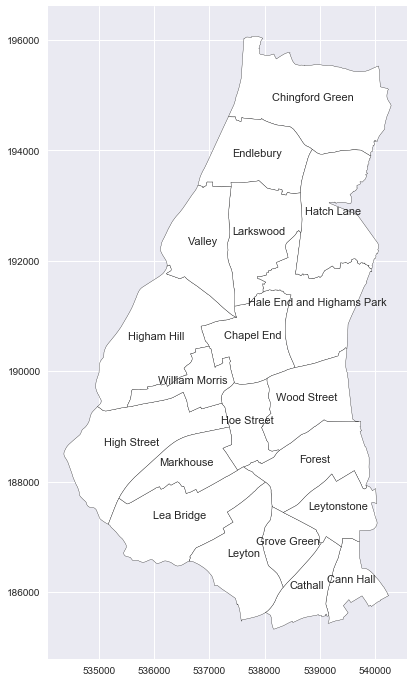

In [387]:
# Let's dissolve the wards and have a look at what they look like.
# First join in wards data.
#wf_lsoas = wf_lsoas.merge(lookup[['LSOA11CD','WD17CD','WD17NM']], left_on = 'lsoa11cd',right_on = 'LSOA11CD')
wf_wards = wf_lsoas.dissolve(by = 'WD17CD')

f, ax = plt.subplots(figsize = (8,12))

wf_wards.plot(edgecolor = 'k',facecolor='w',ax=ax)
ax.set_aspect('equal')

# Annotate with Ward names
for idx, row in wf_wards.iterrows():
    # get coords of centroid
    x,y = row['geometry'].centroid.xy
    ax.annotate(row['WD17NM'],xy = (x[0],y[0]), ha='center',fontsize=11)

In [388]:
# Let's look at some basic aggregates for commuting
wards = flows_melt.groupby('WD17CD')

# Define functions to pass to agg to get different percentile values
def perc10(x): return np.percentile(x,q=10)
def perc25(x): return np.percentile(x,q=25)
def perc75(x): return np.percentile(x,q=75)
def perc90(x): return np.percentile(x,q=90)

ward_flows = wards['distance'].agg([len,np.mean,np.median,np.std,perc10,perc25,perc75,perc90,min,max])
ward_flows.head()

,len,mean,median,std,perc10,perc25,perc75,perc90,min,max
WD17CD,,,,,,,,,,
E05000590,4556.0,8787.225383,8011.927933,6778.721506,1881.642313,4282.166207,11358.748480,15339.279007,0.000578,72913.062438
E05000591,4222.0,8606.368800,7525.370049,7004.848246,1708.098271,4175.328093,10860.943896,15582.736549,0.000174,75973.981030
E05000592,5049.0,9017.254952,9108.230583,7094.041222,1268.455866,3314.732969,12277.542400,15755.523456,0.000336,75419.761979
E05000593,3615.0,10772.046593,10718.878416,7620.949702,2061.500733,4768.724408,15219.703881,17924.282063,14.440013,70694.188602
E05000594,3868.0,9794.876282,9322.798084,7191.885595,1580.764057,3999.866166,14017.727574,16954.180425,58.935009,72796.935959


In [389]:
# merge ward_flows with wf_wards
wf_wards = wf_wards.merge(ward_flows,left_index=True, right_index=True)
wf_wards.head()

,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areashape,st_lengthshape,LSOA11CD,WD17NM,len,mean,median,std,perc10,perc25,perc75,perc90,min,max
WD17CD,,,,,,,,,,,,,,,,,,,
E05000590,"POLYGON ((540005.3920553828 186282.6493260076,...",E01004327,Waltham Forest 028A,Waltham Forest 028A,4219,117003.306066,2140.924228,E01004327,Cann Hall,4556.0,8787.225383,8011.927933,6778.721506,1881.642313,4282.166207,11358.748480,15339.279007,0.000578,72913.062438
E05000591,"POLYGON ((538979.9417895557 185585.0874753907,...",E01004335,Waltham Forest 027A,Waltham Forest 027A,4227,119911.627285,2358.364776,E01004335,Cathall,4222.0,8606.368800,7525.370049,7004.848246,1708.098271,4175.328093,10860.943896,15582.736549,0.000174,75973.981030
E05000592,"POLYGON ((538395.3100701873 190523.7715136193,...",E01004342,Waltham Forest 011A,Waltham Forest 011A,4234,359476.891369,3614.417406,E01004342,Chapel End,5049.0,9017.254952,9108.230583,7094.041222,1268.455866,3314.732969,12277.542400,15755.523456,0.000336,75419.761979
E05000593,"POLYGON ((537731.6465616385 194572.9126107681,...",E01004349,Waltham Forest 001A,Waltham Forest 001A,4241,637008.931749,5355.889874,E01004349,Chingford Green,3615.0,10772.046593,10718.878416,7620.949702,2061.500733,4768.724408,15219.703881,17924.282063,14.440013,70694.188602
E05000594,"POLYGON ((537351.4905885814 193343.3230575114,...",E01004355,Waltham Forest 004A,Waltham Forest 004A,4247,244815.201393,2828.423821,E01004355,Endlebury,3868.0,9794.876282,9322.798084,7191.885595,1580.764057,3999.866166,14017.727574,16954.180425,58.935009,72796.935959


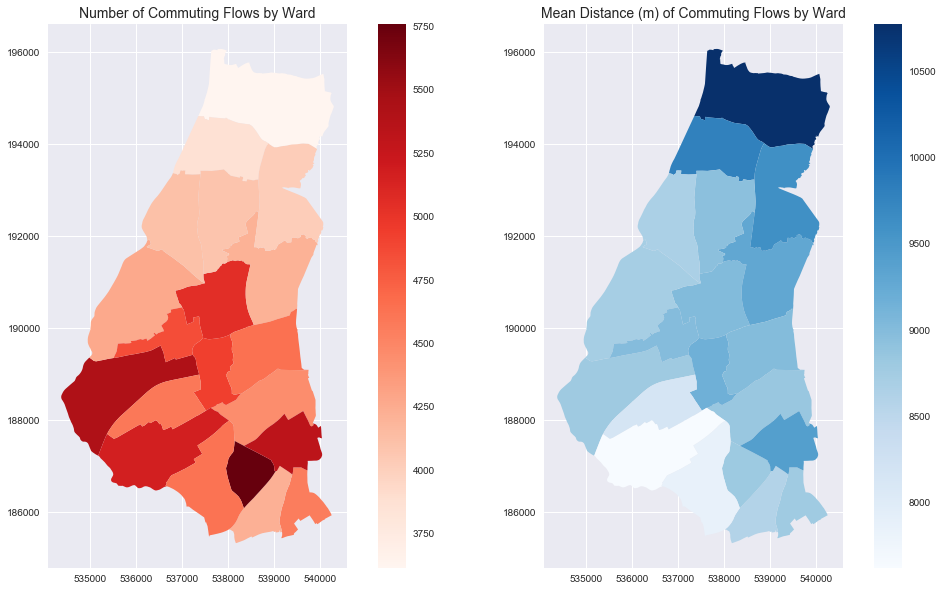

In [150]:
# Let's have a quick look for any spatial pattern at ward level.
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

# Plot number of flows on left axis
wf_wards.plot(column = 'len', cmap = 'Reds', ax=ax1)
ax1.set_aspect('equal')
# Add colorbar (NB legend=True) adds it to the wrong axis
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=wf_wards['len'].min(), vmax=wf_wards['len'].max()))
sm._A = []
f.colorbar(sm, ax=ax1)

ax1.set_title('Number of Commuting Flows by Ward', fontsize = 14)

# Plot average flwo distance on right axis
wf_wards.plot(column = 'mean', cmap = 'Blues', ax=ax2)
ax2.set_aspect('equal')
# Add colorbar (NB legend=True) adds it to the wrong axis
sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=wf_wards['mean'].min(), vmax=wf_wards['mean'].max()))
sm2._A = []
f.colorbar(sm2, ax=ax2)

ax2.set_title('Mean Distance (m) of Commuting Flows by Ward', fontsize = 14)

plt.subplots_adjust(wspace=-0.2)

# Interesting north/south part in number of flows and flows distances.

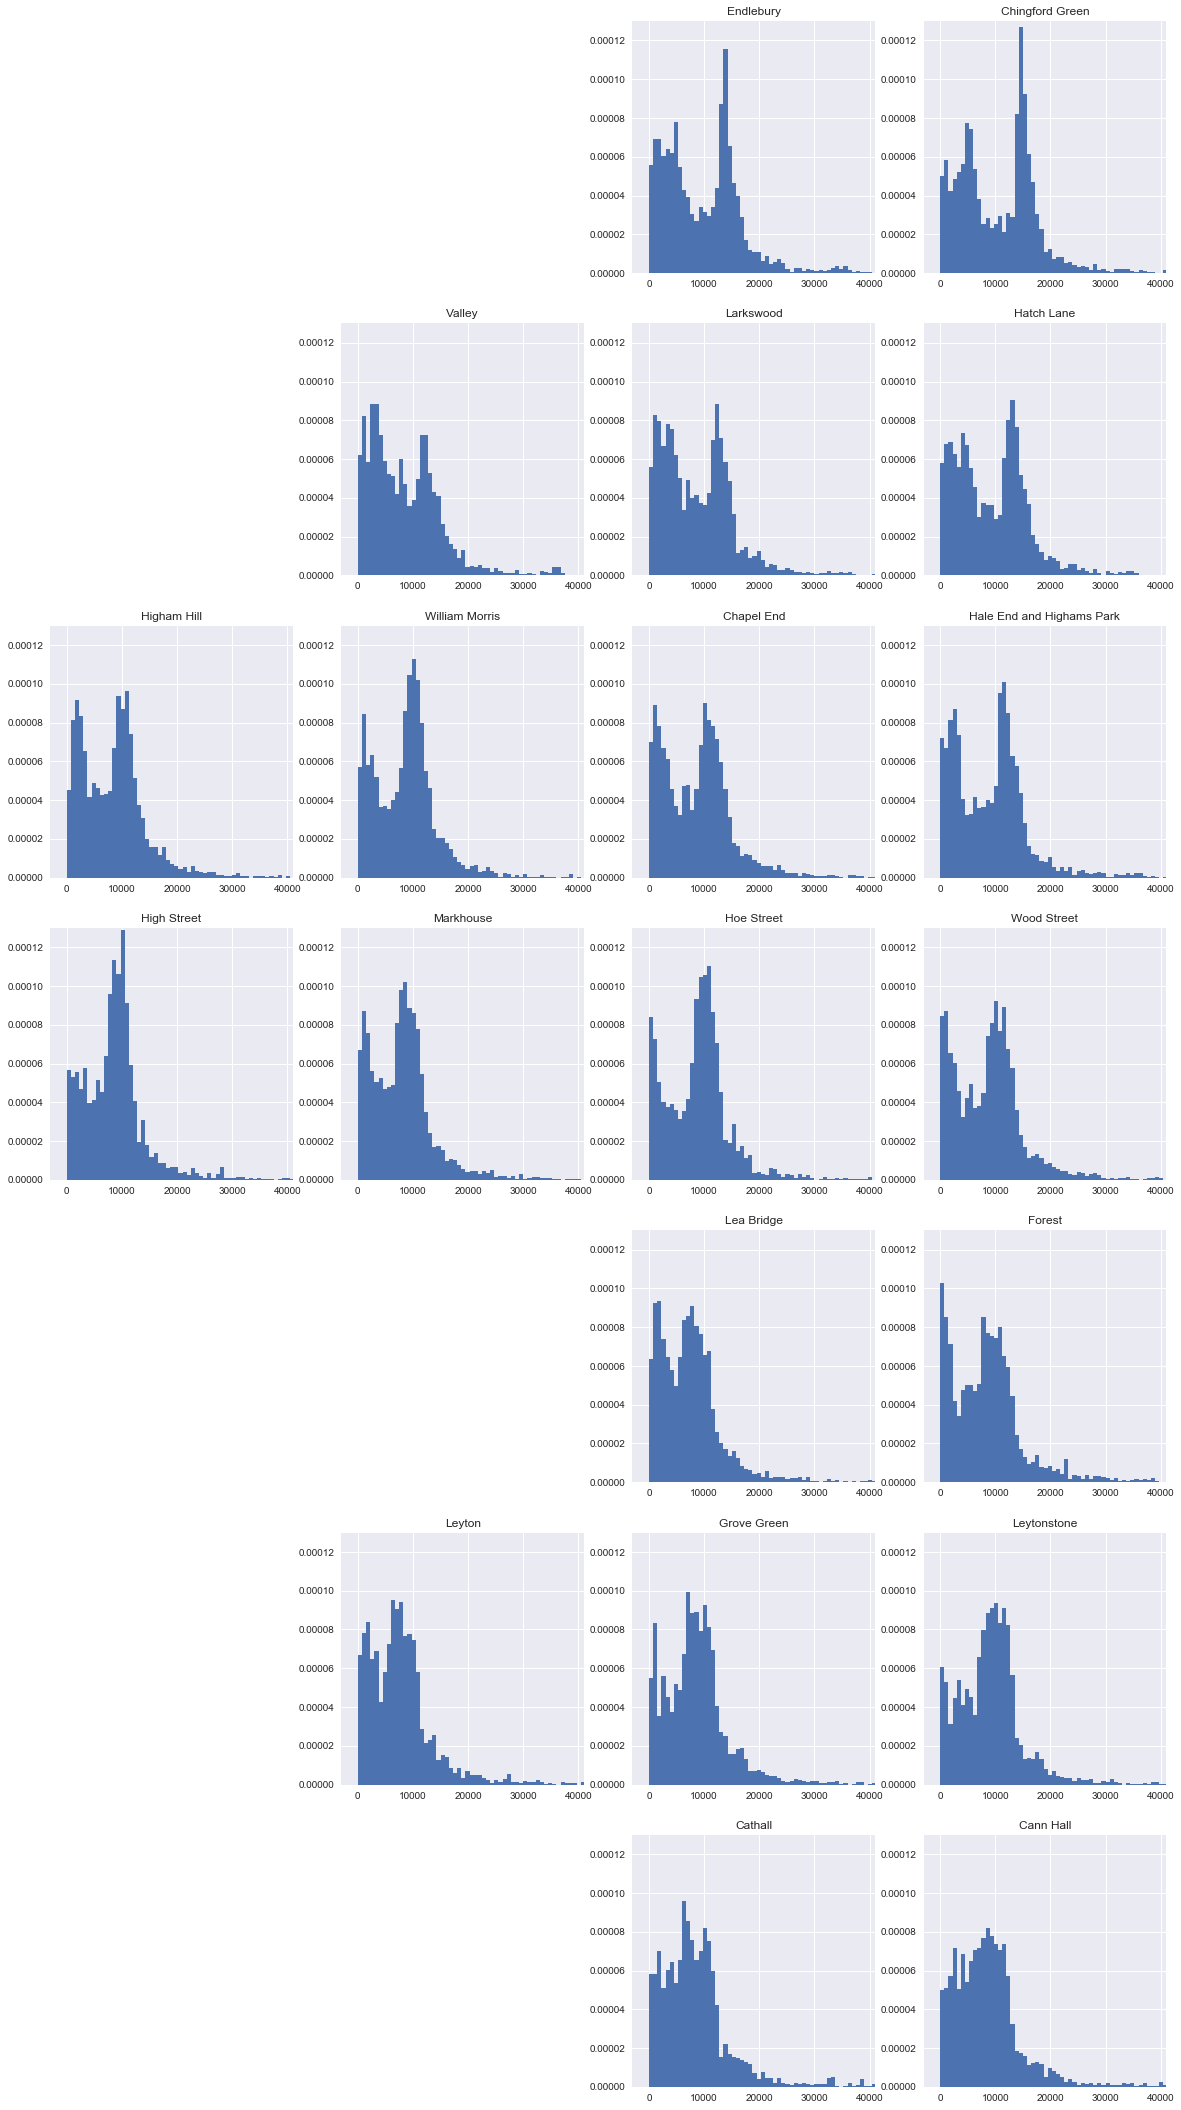

In [490]:
# Now let's look at the distributions of those flows.
# Set up the axes so that they're ordered pseudo-geographically. Catch all the axes separately.
f, ((ax11, ax21, ax31, ax41),
    (ax12, ax22, ax32, ax42),
    (ax13, ax23, ax33, ax43),
    (ax14, ax24, ax34, ax44),
    (ax15, ax25, ax35, ax45),
    (ax16, ax26, ax36, ax46),
    (ax17, ax27, ax37, ax47))= plt.subplots(7,4,figsize=(20,38))
# Turn off the axes that we don't need
ax11.set_axis_off(), ax21.set_axis_off(), ax12.set_axis_off(), ax15.set_axis_off(), ax25.set_axis_off()
ax16.set_axis_off(), ax17.set_axis_off(), ax27.set_axis_off()

# Now in order of axes
# Some common variables for uniform drawing.
var = 'distance'
bins = range(0,80000,750)
density = True
xlim = [-3000,41000]
ylim = [0,0.00013]

#flows_melt['log_distance'] = np.log(flows_melt['distance'])
#var = 'log_distance'
#bins = np.arange(-5,12,0.25)
#density = True
#xlim = [-5,12]
#ylim = [0,1.3]

# ax31 - Endlebury
ax31.set_title("Endlebury")
counts1, bins1, bars1 = ax31.hist(flows_melt[flows_melt['WD17NM'] == "Endlebury"][var],bins=bins, density = density)
ax31.set_xlim(xlim)
ax31.set_ylim(ylim)

# ax41 - Chingford Green
ax41.set_title("Chingford Green")
counts2, bins2, bars2 = ax41.hist(flows_melt[flows_melt['WD17NM'] == "Chingford Green"][var],bins=bins, density = density)
ax41.set_xlim(xlim)
ax41.set_ylim(ylim)

# ax22 - Valley
ax22.set_title("Valley")
counts3, bins3, bars3 = ax22.hist(flows_melt[flows_melt['WD17NM'] == "Valley"][var],bins=bins, density = density)
ax22.set_xlim(xlim)
ax22.set_ylim(ylim)

# ax32 - Larkswood
ax32.set_title("Larkswood")
counts4, bins4, bars4 = ax32.hist(flows_melt[flows_melt['WD17NM'] == "Larkswood"][var],bins=bins, density = density)
ax32.set_xlim(xlim)
ax32.set_ylim(ylim)

# ax42 - Hatch Lane
ax42.set_title("Hatch Lane")
counts5, bins5, bars5 = ax42.hist(flows_melt[flows_melt['WD17NM'] == "Hatch Lane"][var],bins=bins, density = density)
ax42.set_xlim(xlim)
ax42.set_ylim(ylim)

# ax13 - Higham Hill
ax13.set_title("Higham Hill")
counts6, bins6, bars6 = ax13.hist(flows_melt[flows_melt['WD17NM'] == "Higham Hill"][var],bins=bins, density = density)
ax13.set_xlim(xlim)
ax13.set_ylim(ylim)

# ax23 - William Morris
ax23.set_title("William Morris")
counts7, bins7, bars7 = ax23.hist(flows_melt[flows_melt['WD17NM'] == "William Morris"][var],bins=bins, density = density)
ax23.set_xlim(xlim)
ax23.set_ylim(ylim)

# ax33 - Chapel End
ax33.set_title("Chapel End")
counts8, bins8, bars8 = ax33.hist(flows_melt[flows_melt['WD17NM'] == "Chapel End"][var],bins=bins, density = density)
ax33.set_xlim(xlim)
ax33.set_ylim(ylim)

# ax43 - Hale End and Highams Park
ax43.set_title("Hale End and Highams Park")
counts9, bins9, bars9 = ax43.hist(flows_melt[flows_melt['WD17NM'] == "Hale End and Highams Park"][var],bins=bins, density = density)
ax43.set_xlim(xlim)
ax43.set_ylim(ylim)

# ax14 - High Street
ax14.set_title("High Street")
counts10, bins10, bars10 = ax14.hist(flows_melt[flows_melt['WD17NM'] == "High Street"][var],bins=bins, density = density)
ax14.set_xlim(xlim)
ax14.set_ylim(ylim)

# ax24 - Markhouse
ax24.set_title("Markhouse")
counts11, bins11, bars11 = ax24.hist(flows_melt[flows_melt['WD17NM'] == "Markhouse"][var],bins=bins, density = density)
ax24.set_xlim(xlim)
ax24.set_ylim(ylim)

# ax34 - Hoe Street
ax34.set_title("Hoe Street")
counts12, bins12, bars12 = ax34.hist(flows_melt[flows_melt['WD17NM'] == "Hoe Street"][var],bins=bins, density = density)
ax34.set_xlim(xlim)
ax34.set_ylim(ylim)

# ax44 - Hoe Street
ax44.set_title("Wood Street")
counts13, bins13, bars13 = ax44.hist(flows_melt[flows_melt['WD17NM'] == "Wood Street"][var],bins=bins, density = density)
ax44.set_xlim(xlim)
ax44.set_ylim(ylim)

# ax35 - Leabridge
ax35.set_title("Lea Bridge")
counts14, bins14, bars14 = ax35.hist(flows_melt[flows_melt['WD17NM'] == "Lea Bridge"][var],bins=bins, density = density)
ax35.set_xlim(xlim)
ax35.set_ylim(ylim)

# ax45 - Forest
ax45.set_title("Forest")
counts15, bins15, bars15 = ax45.hist(flows_melt[flows_melt['WD17NM'] == "Forest"][var],bins=bins, density = density)
ax45.set_xlim(xlim)
ax45.set_ylim(ylim)

# ax26 - Leyton
ax26.set_title("Leyton")
counts16, bins16, bars16 = ax26.hist(flows_melt[flows_melt['WD17NM'] == "Leyton"][var],bins=bins, density = density)
ax26.set_xlim(xlim)
ax26.set_ylim(ylim)

# ax36 - Grove Green
ax36.set_title("Grove Green")
counts17, bins17, bars17 = ax36.hist(flows_melt[flows_melt['WD17NM'] == "Grove Green"][var],bins=bins, density = density)
ax36.set_xlim(xlim)
ax36.set_ylim(ylim)

# ax46 - Leytonstone
ax46.set_title("Leytonstone")
counts18, bins18, bars18 = ax46.hist(flows_melt[flows_melt['WD17NM'] == "Leytonstone"][var],bins=bins, density = density)
ax46.set_xlim(xlim)
ax46.set_ylim(ylim)

# ax37 - Cathall
ax37.set_title("Cathall")
counts19, bins19, bars19 = ax37.hist(flows_melt[flows_melt['WD17NM'] == "Cathall"][var],bins=bins, density = density)
ax37.set_xlim(xlim)
ax37.set_ylim(ylim)

# ax47 - Cann Hall
ax47.set_title("Cann Hall")
counts20, bins20, bars20 = ax47.hist(flows_melt[flows_melt['WD17NM'] == "Cann Hall"][var],bins=bins, density = density)
ax47.set_xlim(xlim)
ax47.set_ylim(ylim);

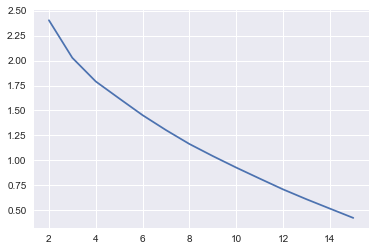

In [491]:
# Looking at the distributions of commuting flows for each ward, there seem to be some patterns.
# Let's see if we can cluster wards by commuting flow distributions.
# We'll assess similarity by looking at the pairwise intersection of the histograms of the wards
# NB This is basically a Jaccard Similarity
def histogram_intersection(h1, h2, bins):
   bins = np.diff(bins)
   sm = 0
   for i in range(len(bins)):
       sm += min(bins[i]*h1[i], bins[i]*h2[i])
   return sm

# Make the dissimilarity matrix
hists = [counts1, counts2, counts3, counts4, counts5, counts6, counts7, counts8, counts9, counts10,
        counts11, counts12, counts13, counts14, counts15, counts16, counts17, counts18, counts19, counts20]

mat = []
for i in hists:
    row = []
    for j in hists:
        # 1.0 for dissimilarity
        row.append(1.0-histogram_intersection(i,j,bins1))
    mat.append(row)
mat = np.array(mat)

errors = []
for n in [2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    clust,err,ts = pc.kmedoids(mat,n,100000)
    errors.append(err)

plt.plot([2,3,4,5,6,7,8,9,10,11,12,13,14,15],errors)
# The 'elbow rule' suggests that k=3 is a reasonable number of clusters.

In [643]:
# These are the bandwidths of the histogram, to which the cluster could be sensitive, with cluster allocation given.

# 2500m: [0,0,0,0,0,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2]
# 2250m: [0,0,0,0,0,1,1,1,0,2,2,1,1,2,1,2,2,1,2,2]
# 2000m: [0,0,0,0,0,1,1,1,0,1,2,1,1,2,1,2,2,1,2,2]
# 1750m: [0,0,0,0,0,1,1,1,1,2,2,1,1,2,2,2,2,2,2,2]
# 1500m: [0,0,0,0,0,1,1,1,0,1,2,1,1,2,1,2,2,1,2,2]
# 1250m: [0,0,0,0,0,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2]
# 1000m: [0,0,0,0,0,1,1,1,1,2,2,1,1,2,2,2,2,2,2,2]
# 750m:  [0,0,0,0,0,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2]
# 500m:  [0,0,0,0,0,1,1,1,0,2,2,1,1,2,2,2,2,1,2,2]
# 250m:  [0,0,0,0,0,1,1,1,1,2,2,1,1,2,2,2,2,1,2,2]

# Agree: [0,0,0,0,0,1,1,1,x,x,2,1,1,2,x,2,2,x,2,2]

# Across a range of scales, 4 wards are inconsistent in their classification.
# In each case I go for the majority group.

# Final: [0,0,0,0,0,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2]

In [504]:
# NB clustering solutions were obtained for the raw and log distances producing slightly different solutions (4 wards)
# Both indicated that a 3 cluster solution was good.

wards = ["Endlebury","Chingford Green","Valley","Larkswood","Hatch Lane","Higham Hill","William Morris","Chapel End",
        "Hale End and Highams Park","High Street","Markhouse","Hoe Street","Wood Street","Lea Bridge","Forest","Leyton",
        "Grove Green","Leytonstone","Cathall","Cann Hall"]
solutions = [0,0,0,0,0,1,1,1,1,2,2,1,1,2,1,2,2,1,2,2]

ward_clust = pd.DataFrame({'WD17NM':wards,'solution':solutions})

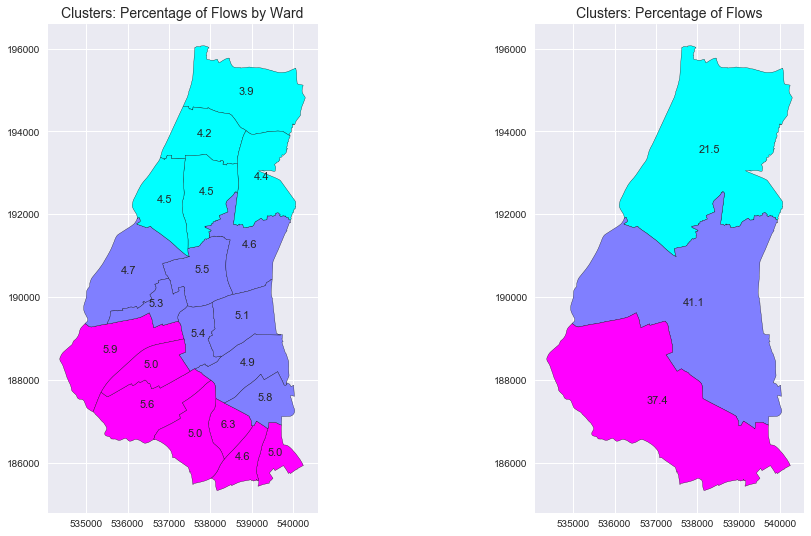

In [573]:
# Merge the clustering solution with the wards data
#wf_wards = wf_wards.merge(ward_clust,on='WD17NM')

#n_flows = wf_wards['len'].sum()
#wf_wards['prop_flows'] = wf_wards['len']/n_flows

# Quick map of the cluster solutions
f, [ax1,ax2] = plt.subplots(1,2,figsize=(16,9))

wf_wards.plot(column = 'solution', cmap = 'cool',edgecolor = 'k',ax=ax1)
ax1.set_aspect('equal')
ax1.set_title('Clusters: Percentage of Flows by Ward',fontsize=14)
# Annotate with flow proportions
for idx, row in wf_wards.iterrows():
    # get coords of centroid
    x,y = row['geometry'].centroid.xy
    ax1.annotate(round(row['prop_flows'],3)*100,xy = (x[0],y[0]), ha='center',fontsize=11)

# ax2
clusters = wf_wards.dissolve(by = 'solution',aggfunc='sum')
clusters.plot(cmap = 'cool',edgecolor = 'k',ax=ax2)
ax2.set_aspect('equal')
ax2.set_title('Clusters: Percentage of Flows',fontsize=14)
for idx, row in clusters.iterrows():
    # get coords of centroid
    x,y = row['geometry'].centroid.xy
    ax2.annotate(round(row['prop_flows'],3)*100,xy = (x[0],y[0]), ha='center',fontsize=11)


Text(0.5,1,'Combined')

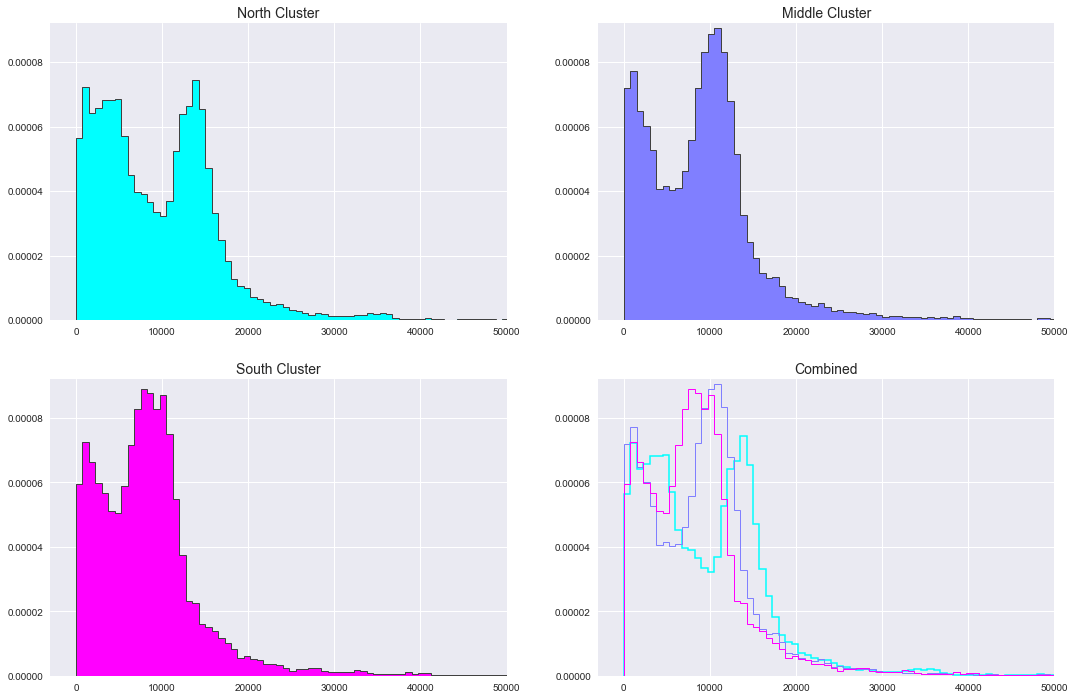

In [679]:
# Let's look at the distributions of these three clusters.
f,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(18,12))

# clusters
cluster = {0:["Endlebury","Chingford Green","Valley","Larkswood","Hatch Lane"],
           1:["Higham Hill","William Morris","Chapel End","Hale End and Highams Park","Hoe Street","Wood Street","Forest","Leytonstone"],
           2:["High Street","Markhouse","Lea Bridge","Leyton","Grove Green","Cathall","Cann Hall"]}

clust_color = {0:[0.0,1.0,1.0],
               1:[0.50196078,  0.49803922,  1.],
               2:[1.0,0.0,1.0]}

var = 'distance'

xlim = [-3000,50000]
ylim = [0,0.000092]

# ax1 - CLuster 0
ax1.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[0])][var],bins=bins,color = clust_color[0], density = density)
ax1.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[0])][var],bins=bins,color='0.25', density = density, histtype='step',lw=1)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

# ax2 - CLuster 1
ax2.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[1])][var],bins=bins,color = clust_color[1], density = density)
ax2.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[1])][var],bins=bins,color='0.25', density = density, histtype='step',lw=1)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# ax3 - CLuster 2
ax3.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[2])][var],bins=bins,color = clust_color[2], density = density)
ax3.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[2])][var],bins=bins,color='0.25', density = density, histtype='step',lw=1)
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

# ax4 - All clusters.
ax4.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[0])][var],bins=bins,color = clust_color[0], density = density, histtype='step',lw=1.5)
ax4.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[1])][var],bins=bins,color = clust_color[1], density = density, histtype='step',lw=1)
ax4.hist(flows_melt[flows_melt['WD17NM'].isin(cluster[2])][var],bins=bins,color = clust_color[2], density = density, histtype='step',lw=1)
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)

ax1.set_title('North Cluster',fontsize=14)
ax2.set_title('Middle Cluster',fontsize=14)
ax3.set_title('South Cluster',fontsize=14)
ax4.set_title('Combined',fontsize=14)

# These do see to be broadly different distributions:
# The position of the 2nd peak moves left as you go south in the borough.
# The first peak is more substantial in the northerly region.

Text(0.5,1,'Combined')

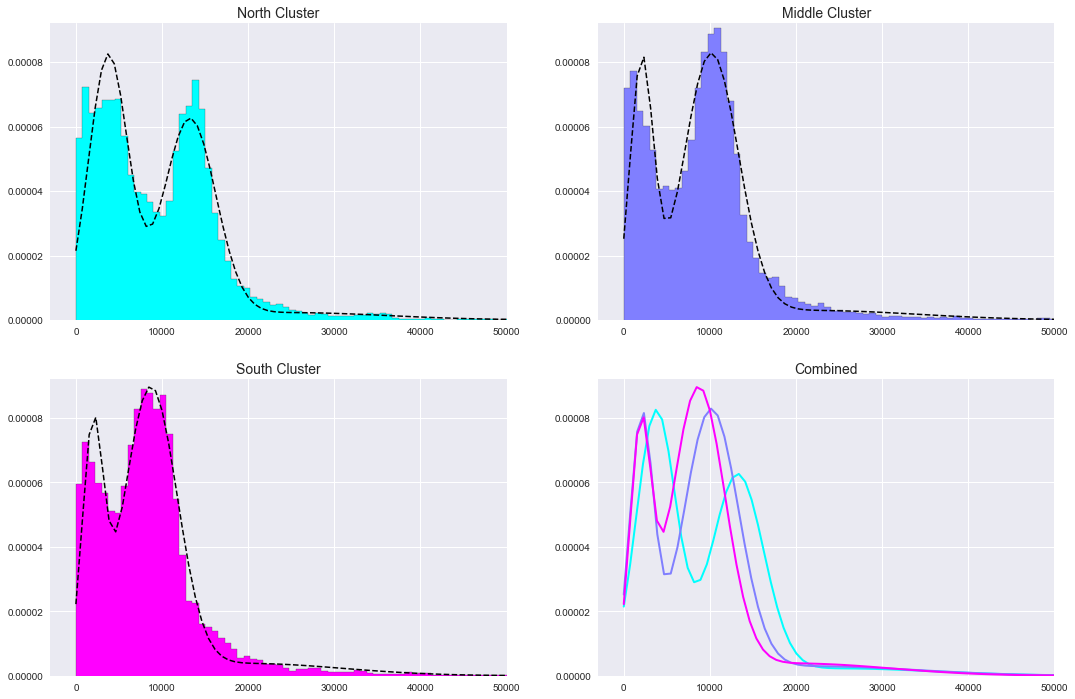

In [681]:
# Finally, let's see if we can simulate each of these cluster distributions.
# We'll use Gaussian Mixture Models
# Fit the distribution of commuting distance as a gaussian mixture model.
# 3 components works pretty well in each case.

# Let's look at the distributions of these three clusters.
f,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(18,12))

# clusters
cluster = {0:["Endlebury","Chingford Green","Valley","Larkswood","Hatch Lane"],
           1:["Higham Hill","William Morris","Chapel End","Hale End and Highams Park","Hoe Street","Wood Street","Forest","Leytonstone"],
           2:["High Street","Markhouse","Lea Bridge","Leyton","Grove Green","Cathall","Cann Hall"]}

clust_color = {0:[0.0,1.0,1.0],
               1:[0.50196078,  0.49803922,  1.],
               2:[1.0,0.0,1.0]}

var = 'distance'

xlim = [-3000,50000]
ylim = [0,0.000092]

# ax1 - CLuster 0
data0 = np.expand_dims(flows_melt[flows_melt['WD17NM'].isin(cluster[0])]['distance'],1)
gmm0 = GaussianMixture(n_components=3)
gmm0 = gmm0.fit(X = data0)

# Evaluate GMM
gmm0_x = np.linspace(0,data0.max(),100)
gmm0_y = np.exp(gmm0.score_samples(gmm0_x.reshape(-1,1)))

ax1.hist(data0,bins=bins,density=True, color=clust_color[0])
ax1.hist(data0,bins=bins,density=True, color='0.25',histtype='step')
ax1.plot(gmm0_x, gmm0_y, color="k",linestyle='dashed', lw=1.5, label="GMM")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

# ax2 - CLuster 1
data1 = np.expand_dims(flows_melt[flows_melt['WD17NM'].isin(cluster[1])]['distance'],1)
gmm1 = GaussianMixture(n_components=3)
gmm1 = gmm1.fit(X = data1)

# Evaluate GMM
gmm1_x = np.linspace(0,data1.max(),100)
gmm1_y = np.exp(gmm1.score_samples(gmm1_x.reshape(-1,1)))

ax2.hist(data1,bins=bins,density=True,color=clust_color[1])
ax2.hist(data1,bins=bins,density=True, color='0.25',histtype='step')
ax2.plot(gmm1_x, gmm1_y, color="k",linestyle='dashed', lw=1.5, label="GMM")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# ax3 - CLuster 2
data2 = np.expand_dims(flows_melt[flows_melt['WD17NM'].isin(cluster[2])]['distance'],1)
gmm2 = GaussianMixture(n_components=3)
gmm2 = gmm2.fit(X = data2)

# Evaluate GMM
gmm2_x = np.linspace(0,data2.max(),100)
gmm2_y = np.exp(gmm2.score_samples(gmm2_x.reshape(-1,1)))

ax3.hist(data2,bins=bins,density=True,color=clust_color[2])
ax3.hist(data2,bins=bins,density=True, color='0.25',histtype='step')
ax3.plot(gmm2_x, gmm2_y, color="k",linestyle='dashed', lw=1.5, label="GMM")
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

# ax4 - Plot curves
ax4.plot(gmm0_x, gmm0_y, color=clust_color[0], lw=2, label="North Cluster")
ax4.plot(gmm1_x, gmm1_y, color=clust_color[1], lw=2, label="Middle Cluster")
ax4.plot(gmm2_x, gmm2_y, color=clust_color[2], lw=2, label="South Cluster")
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)

# titles
ax1.set_title('North Cluster',fontsize=14)
ax2.set_title('Middle Cluster',fontsize=14)
ax3.set_title('South Cluster',fontsize=14)
ax4.set_title('Combined',fontsize=14)

In [758]:
# Now let's get the mixture model parameters.

# Cluster 1 (North Cluster)
# Means: 3765, 13214, 24941
# Std.: 2295, 3028, 11202
# Weights: 0.47, 0.47,0.06

# Cluster 2 (Middle Cluster)
# Means: 2067, 10150, 21956
# Std.: 1347, 3179, 12065
# Weights: 0.26, 0.65, 0.09

# Cluster 3 (South Cluster)
# Means: 1949, 8671, 19921
# Std.: 1214, 3079, 11016
# Weights: 0.22, 0.68, 0.1

# Now let's simulate a full distribution based on the three different clusters and see how it performs.
def simdist(means = [0], stds = [1], weights = [1], n = 100):
    simdata = []
    distribs = [norm(mean, std) for (mean, std) in zip(means, stds)]
    pick = np.cumsum(weights)
    for i in range(0,int(n)):
        rn = np.random.rand()
        if rn < pick[0]:
            simdata.append(abs(distribs[0].rvs()))
        elif rn < pick[1]:
            simdata.append(abs(distribs[1].rvs()))
        else:
            simdata.append(abs(distribs[2].rvs()))
    return simdata

# Get the n of each cluster
clust_n = clusters['len'].to_dict()
# Make a dict of the model parameters
models = {0: {'means':[3765,13214,24941],'stds':[2295,3028,11202],'weights':[0.47,0.47,0.06]},
          1: {'means':[2067,10150,21956],'stds':[1347,3179,12065],'weights':[0.26,0.65,0.09]},
          2: {'means':[1949,8671,19921],'stds':[1214,3079,11016],'weights':[0.22,0.68,0.1]}}

new_data = []
for c, n in clust_n.items():
    new_data += simdist(models[c]['means'],models[c]['stds'],models[c]['weights'],n)
    

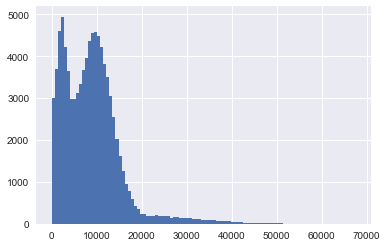

In [759]:
plt.hist(new_data,bins=100);

In [761]:
# See the data generating mechanism performs agains the data itself
np.corrcoef(sorted(flows_melt['distance']),sorted(new_data))

array([[ 1.        ,  0.99323432],
       [ 0.99323432,  1.        ]])

Text(0,0.5,'Synthetic Commute Distance (m)')

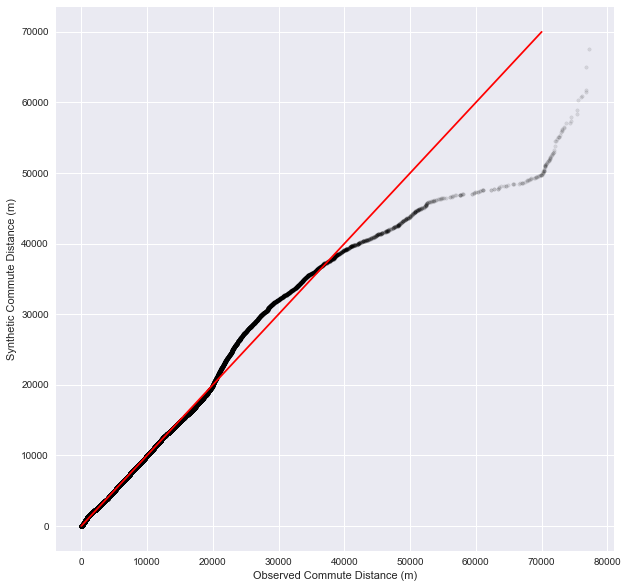

In [763]:
f, ax = plt.subplots(figsize=(10,10))

ax.scatter(sorted(flows_melt['distance']),sorted(new_data),marker='.', color='k',alpha=0.1)
ax.plot([0,70000],[0,70000],color='r')
ax.set_xlabel("Observed Commute Distance (m)")
ax.set_ylabel("Synthetic Commute Distance (m)")

# NB - most of the data lie below 20km (c.95%) so this is actually pretty good.

In [778]:
# Finally, let's generate by ward, using the relevant model based on the ward's cluster.
ward_names = wf_wards['WD17NM'].tolist()
ward_clusters = pd.Series(wf_wards['solution'].values, index=wf_wards['WD17NM']).to_dict()
ward_flows = pd.Series(wf_wards['len'].values, index=wf_wards['WD17NM']).to_dict()

new_data = []
ward_data = {}
for ward in ward_names:
    c = ward_clusters[ward]
    new_data += simdist(models[c]['means'],models[c]['stds'],models[c]['weights'],ward_flows[ward])
    ward_data[ward] = simdist(models[c]['means'],models[c]['stds'],models[c]['weights'],ward_flows[ward])

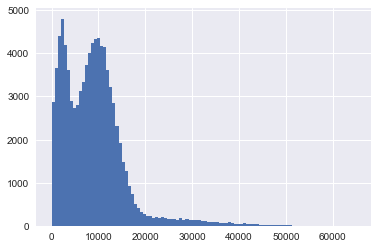

In [776]:
plt.hist(new_data,bins=100);

In [779]:
# See the data generating mechanism performs agains the data itself
np.corrcoef(sorted(flows_melt['distance']),sorted(new_data))

array([[ 1.       ,  0.9923468],
       [ 0.9923468,  1.       ]])

Text(0.5,1,'Mean Commute Distance (Simulated)')

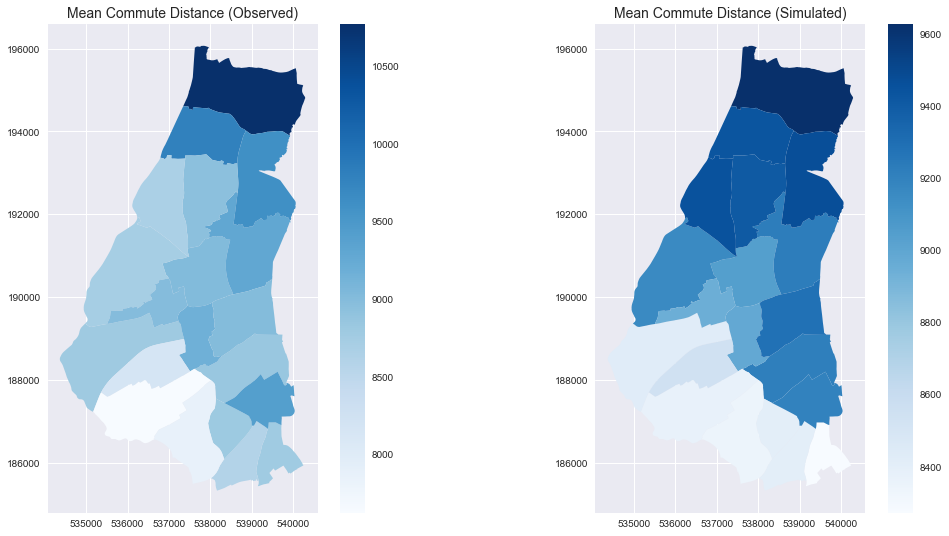

In [802]:
ward_means = {}
for w in ward_data.keys():
    ward_means[w] = np.mean(ward_data[w])
ward_means = pd.DataFrame.from_dict(ward_means,orient='index').reset_index()
ward_means.rename(columns={'index':'WD17NM',0:'sim_mean'},inplace=True)
# Merge simulated means with geom
wf_wards = wf_wards.merge(ward_means,on='WD17NM')

# Now map the means
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,9))
wf_wards.plot(column = 'mean', cmap = 'Blues', ax=ax1)
ax1.set_aspect('equal')

# Add colorbar (NB legend=True) adds it to the wrong axis
sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=wf_wards['mean'].min(), vmax=wf_wards['mean'].max()))
sm1._A = []
f.colorbar(sm1, ax=ax1)
ax1.set_title('Mean Commute Distance (Observed)', fontsize=14)

# Now map the simulated means
wf_wards.plot(column = 'sim_mean', cmap = 'Blues', ax=ax2)
ax2.set_aspect('equal')

# Add colorbar (NB legend=True) adds it to the wrong axis
sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=wf_wards['sim_mean'].min(), vmax=wf_wards['sim_mean'].max()))
sm2._A = []
f.colorbar(sm2, ax=ax2)
ax2.set_title('Mean Commute Distance (Simulated)', fontsize=14)